# **Attention Is All You Need**

Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. arXiv preprint arXiv:1706.03762.

Most of the code is quoted from the website below:

*https://wikidocs.net/31379*

## **Default Setting**

In [ ]:
# !pip install -q tensorflow_datasets tensorflow_text adabelief-tf

In [1]:
import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf

import collections
import logging
import os
import re
import string
import sys
import time

import numpy as np
import pandas as pd

from adabelief_tf import AdaBeliefOptimizer
from matplotlib import pyplot as plt
from pathlib import Path

print(f"tf.__version__: {tf.__version__}")
print(f"tfds.__version__: {tfds.__version__}")
# print(f"text.__version__: {text.__version__}")

tf.__version__: 2.4.1
tfds.__version__: 4.2.0


In [2]:
logging.getLogger("tensorflow").setLevel(logging.ERROR)  # suppress warnings

In [3]:
# tf.keras.mixed_precision.set_global_policy("mixed_float16") ## Mixed precision.

In [4]:
# If you wanna avoid below error, you need to run below codes when you start kernel.

# UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, 
# so try looking to see if a warning log message was printed above. [Op:Conv2D]

# Ref: https://blog.naver.com/vft1500/221793591386

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs.")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs.


In [5]:
!nvidia-smi

Fri Apr 23 09:26:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Graphics Device     On   | 00000000:0A:00.0  On |                  N/A |
|  0%   46C    P2    33W / 220W |    872MiB /  7979MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
class HParams(object):
    def __init__(self):
        self.dtype = tf.float32 ## mixed precision policy
        
        self.tr_num = None
        self.vl_num = None
        self.ts_num = None
        
        self.steps_per_epoch = None
        self.validation_steps = None
        self.steps_per_execution = None
        
        self.d_model = 128
        self.num_layers = 4
        self.num_heads = 8
        self.dff = 512
        
        self.buffer_size = 20_000
        self.global_batch_size = 64
        self.auto = tf.data.AUTOTUNE
        
        self.init_lr = 1e-3
        self.min_lr = 1e-5
        self.epochs = 50 ## include warmup epochs
        self.warmup_epochs = int(np.ceil(self.epochs * 0.2))
        self.alpha = 1. / 5

HPARAMS = HParams()

## **Download Datasets**

In [7]:
examples, metadata = tfds.load(
    "ted_hrlr_translate/pt_to_en", 
    with_info = True,
    as_supervised = True
)

tr_examples, vl_examples = examples["train"], examples["validation"]

In [8]:
for pt_examples, en_examples in tr_examples.batch(3).take(1):
    for pt in pt_examples.numpy():
        print(pt.decode("utf-8"))

    print()
    
    for en in en_examples.numpy():
        print(en.decode("utf-8"))

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [9]:
metadata

tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    full_name='ted_hrlr_translate/pt_to_en/1.0.0',
    description="""
    Data sets derived from TED talk transcripts for comparing similar language pairs
    where one is high resource and the other is low resource.
    """,
    config_description="""
    Translation dataset from pt to en in plain text.
    """,
    homepage='https://github.com/neulab/word-embeddings-for-nmt',
    data_path='/home/myunggyo/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0',
    download_size=124.94 MiB,
    dataset_size=10.89 MiB,
    features=Translation({
        'en': Text(shape=(), dtype=tf.string),
        'pt': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('pt', 'en'),
    splits={
        'test': <SplitInfo num_examples=1803, num_shards=1>,
        'train': <SplitInfo num_examples=51785, num_shards=1>,
        'validation': <SplitInfo num_examples=1193, num_shards=1>,
    },
    citation="""@inproceedings{Ye2018WordEmbed

In [10]:
HPARAMS.tr_num = metadata.splits["train"].num_examples
HPARAMS.vl_num = metadata.splits["validation"].num_examples
HPARAMS.ts_num = metadata.splits["test"].num_examples

## **Tokenizing and De-tokenizing**

In [19]:
model_name = "ted_hrlr_translate_pt_en_converter"
Path("assets").mkdir(parents = True, exist_ok = True)
tf.keras.utils.get_file(
    f"{model_name}.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
    cache_dir = "assets", 
    cache_subdir = "", 
    extract = True,
)

'assets/ted_hrlr_translate_pt_en_converter.zip'

In [ ]:
tokenizers = tf.saved_model.load(model_name)

In [13]:
[item for item in dir(tokenizers.en) if not item.startswith("_")]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

### **Tokenize**

Tokenizer maps string(token) to integer.

In [14]:
for en in en_examples.numpy():
    print(en.decode("utf-8"))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [15]:
encoded = tokenizers.en.tokenize(en_examples)

for row in encoded.to_list():
    print(row)

[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


### **Detokenize**

Detokenizer translate from integer to string that can read.

In [16]:
round_trip = tokenizers.en.detokenize(encoded)
for line in round_trip.numpy():
    print(line.decode("utf-8"))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


In [17]:
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability', b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage', b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip', b'##ity', b'.', b'[END]'], [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?', b'[END]'], [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for', b'curiosity', b'.', b'[END]']]>

## **Build Dataset Pipelines**

In [18]:
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    # Convert from ragged to dense, padding with zeros.
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return pt, en

In [19]:
def make_batches(ds):
    return (
        ds
        .cache()
        .repeat()
        .shuffle(HPARAMS.buffer_size)
        .batch(HPARAMS.global_batch_size)
        .map(tokenize_pairs, num_parallel_calls = HPARAMS.auto)
        .prefetch(HPARAMS.auto))


tr_batches = make_batches(tr_examples)
vl_batches = make_batches(vl_examples)

HPARAMS.steps_per_epoch  = np.ceil(HPARAMS.tr_num / HPARAMS.global_batch_size)
HPARAMS.validation_steps = np.ceil(HPARAMS.vl_num / HPARAMS.global_batch_size)
HPARAMS.steps_per_execution = 16

print(f"Global batch size: {HPARAMS.global_batch_size}\n")

print(f"{'Steps per epoch':20s}: {HPARAMS.steps_per_epoch} ({HPARAMS.steps_per_epoch * HPARAMS.global_batch_size} batches)")
print(f"{'Validation steps':20s}: {HPARAMS.validation_steps} ({HPARAMS.validation_steps * HPARAMS.global_batch_size} batches)")
print(f"{'Steps per execution':20s}: {HPARAMS.steps_per_execution}\n")

print(f"tr_batches.element_spec: {tr_batches.element_spec}")
print(f"vl_batches.element_spec: {vl_batches.element_spec}")

Global batch size: 64

Steps per epoch     : 810.0 (51840.0 batches)
Validation steps    : 19.0 (1216.0 batches)
Steps per execution : 16

tr_batches.element_spec: (TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))
vl_batches.element_spec: (TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))


## **Modeling**

### **Positional Encoding**

In [20]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [21]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype = HPARAMS.dtype)

(1, 128, 512)


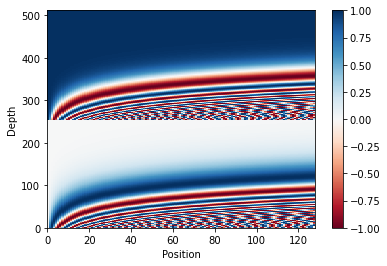

In [22]:
n, d = HPARAMS.d_model, HPARAMS.dff
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

### **Masking**

Mask added (zero) padding to maintain the length of sequences.

In [23]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), dtype = HPARAMS.dtype)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [24]:
print(create_padding_mask(
    tf.constant([[7, 6, 0, 0, 1], 
                 [1, 2, 3, 0, 0], 
                 [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 1. 0.]]]


 [[[0. 0. 0. 1. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(3, 1, 1, 5), dtype=float32)


### **Look-ahead mask**

Mask future tokens.

In [25]:
def create_look_ahead_mask(size):
    return tf.cast(1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0), dtype = HPARAMS.dtype)

In [26]:
print(create_look_ahead_mask(
    tf.random.uniform((1, 3)).shape[1]))

tf.Tensor(
[[0. 1. 1.]
 [0. 0. 1.]
 [0. 0. 0.]], shape=(3, 3), dtype=float32)


### **Scaled Dot-Product Attention**

<img width="80%" src="https://github.com/cawandmilk/paper-implementation/blob/master/papers/%5B021%5D%20Attention%20Is%20All%20You%20Need/assets/scaled_attention.png"/>

In [27]:
def scaled_dot_product_attention(query, key, value, mask):
    ## Attention score matrix
    matmul_qk = tf.matmul(query, key, transpose_b = True)

    ## Scaling
    depth = tf.cast(tf.shape(key)[-1], dtype = HPARAMS.dtype)
    logits = matmul_qk / tf.math.sqrt(depth)

    ## Put a very small negative value in the masking position of the attention score matrix.
    ## Since it is a very small value, the value of the corresponding position in the matrix
    ## becomes 0 after passing the softmax function.
    if mask is not None:
        logits += (mask * -1e9)

    ## The softmax function is executed in the direction of the sentence length of key, which is the last dimension.
    ## attention weight: (batch_size, num_heads, length of query sentence, length of key sentence)
    attention_weights = tf.nn.softmax(logits, axis = -1)

    ## output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    output = tf.matmul(attention_weights, value)

    return output, attention_weights

In [28]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print(f"{'Attention weights are':25s}: {temp_attn}")
    print(f"{'Output is':25s}: {temp_out}")

In [29]:
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype = HPARAMS.dtype)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype = HPARAMS.dtype)  # (4, 2)
temp_q = tf.constant([[0, 10, 0]], dtype = HPARAMS.dtype)  # (1, 3)

print_out(temp_q, temp_k, temp_v)

Attention weights are    : [[0. 1. 0. 0.]]
Output is                : [[10.  0.]]


In [30]:
temp_q = tf.constant([[0, 0, 10]], dtype = HPARAMS.dtype)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are    : [[0.  0.  0.5 0.5]]
Output is                : [[550.    5.5]]


In [31]:
# This query aligns equally with the first and second key,
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype = HPARAMS.dtype)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are    : [[0.5 0.5 0.  0. ]]
Output is                : [[5.5 0. ]]


In [32]:
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype = HPARAMS.dtype)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are    : [[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]]
Output is                : [[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]]


### **Multi-head Attention**

<img width="80%" src="https://github.com/cawandmilk/paper-implementation/blob/master/papers/%5B021%5D%20Attention%20Is%20All%20You%20Need/assets/multi_head_attention.png"/>

In [33]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name = "multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name = name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads ## 64

        ## Dense layer definition corresponding to W_Q, W_K, and W_V.
        self.query_dense = tf.keras.layers.Dense(units = d_model)
        self.key_dense   = tf.keras.layers.Dense(units = d_model)
        self.value_dense = tf.keras.layers.Dense(units = d_model)

        ## Definition of dense layer corresponding to W_O. 
        self.dense = tf.keras.layers.Dense(units = d_model)

    ## A function that splits q, k, v by the number of num_heads.
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape = (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm = [0, 2, 1, 3])

    def call(self, value, key, query, mask):
        batch_size = tf.shape(query)[0]

        ## 1. Passing through dense layers corresponding to WQ, WK, and WV
        query = self.query_dense(query)
        key   = self.key_dense(key)
        value = self.value_dense(value)

        ## 2. Split heads.
        query = self.split_heads(query, batch_size)
        key   = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        ## 3. Scaled dot-product attention.
        scaled_attention, attention_weights = scaled_dot_product_attention(query, key, value, mask) ## no attention weights
        scaled_attention = tf.transpose(scaled_attention, perm = [0, 2, 1, 3])

        ## 4. Concat all heads.
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        ## 5. Passing through the dense layer corresponding to W_O.
        outputs = self.dense(concat_attention)
        
        return outputs, attention_weights

In [34]:
temp_mha = MultiHeadAttention(d_model = 512, num_heads = 8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, key = y, query = y, mask = None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

### **Pointwise Feed Foward Network**

In [35]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation = "relu"),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [36]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

### **Encoder & Decoder Layer**

<img width="80%" src="https://github.com/cawandmilk/paper-implementation/blob/master/papers/%5B021%5D%20Attention%20Is%20All%20You%20Need/assets/transformer.png"/>

In [37]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate = 0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):    
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training = training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training = training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
        return out2

In [38]:
sample_encoder_layer_output = EncoderLayer(
    512, 8, 2048
)(tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [39]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate = 0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training = training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training = training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training = training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [40]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### **Encoder & Decoder**

In [41]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 maximum_position_encoding, rate = 0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        
        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, dtype = HPARAMS.dtype))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training = training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [42]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [43]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                 maximum_position_encoding, rate = 0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, dtype = HPARAMS.dtype))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                   look_ahead_mask, padding_mask)

            attention_weights[f"decoder_layer{i+1}_block1"] = block1
            attention_weights[f"decoder_layer{i+1}_block2"] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [44]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn["decoder_layer2_block2"].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

### **Transformer**

In [45]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [46]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 target_vocab_size, pe_input, pe_target, rate = 0.1):
        super(Transformer, self).__init__()

        self.tokenizer = Encoder(num_layers, d_model, num_heads, dff,
                                 input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
        self.type_casting = tf.keras.layers.Activation("linear", dtype = tf.float32)
        self.create_masks = create_masks
        
    
    def call(self, x, training = None):
        inp, tar, enc_padding_mask, look_ahead_mask, dec_padding_mask = x ## Unpacking
                
        enc_output = self.tokenizer(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
        
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        final_output = self.type_casting(final_output)
        
        return final_output, attention_weights
    
    
    # @tf.function
    def train_step(self, x):
        ## Split elements.
        inp, tar = x
        
        tar_inp = tar[:, :-1]
        tar_real = tar[:, 1:]

        enc_padding_mask, combined_mask, dec_padding_mask = self.create_masks(inp, tar_inp)

        with tf.GradientTape() as tape:
            predictions, _ = self.call((inp, tar_inp, 
                                        enc_padding_mask, 
                                        combined_mask, 
                                        dec_padding_mask), training = True)
            
            loss_value = self.loss(tar_real, predictions)
            scaled_loss = self.optimizer.get_scaled_loss(loss_value)
            
        scaled_gradients = tape.gradient(scaled_loss, self.trainable_variables)
        gradients = self.optimizer.get_unscaled_gradients(scaled_gradients)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.compiled_metrics.update_state(tar_real, predictions)
        
        results = {"loss": loss_value}
        results.update({m.name: m.result() for m in self.metrics})
        
        return results
    
    
    # @tf.function
    def test_step(self, x):
        ## Split elements.
        inp, tar = x
        
        tar_inp = tar[:, :-1]
        tar_real = tar[:, 1:]

        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

        predictions, _ = self.call((inp, tar_inp, 
                                    enc_padding_mask, 
                                    combined_mask, 
                                    dec_padding_mask), training = False)
                
        loss_value = self.loss(tar_real, predictions)

        self.compiled_metrics.update_state(tar_real, predictions)
        
        results = {"loss": loss_value}
        results.update({m.name: m.result() for m in self.metrics})
        
        return results

In [47]:
sample_transformer = Transformer(
    num_layers = 2, d_model = 512, num_heads = 8, dff = 2048,
    input_vocab_size = 8500, target_vocab_size = 8000,
    pe_input = 10000, pe_target = 6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval = 0, maxval = 200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval = 0, maxval = 200)

fn_out, _ = sample_transformer((temp_input, temp_target, None, None, None), training = False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## **Fit**

### **Learning Rate Schedular**

In [48]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, 
        d_model = HPARAMS.d_model, 
        warmup_epochs = HPARAMS.warmup_epochs,
        init_lr = HPARAMS.init_lr,
        min_lr = HPARAMS.min_lr,
        alpha = HPARAMS.alpha,
    ):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_epochs = warmup_epochs
        self.init_lr = init_lr
        self.min_lr = min_lr
        self.alpha = alpha
        
        self.cosine_decay = tf.keras.experimental.CosineDecay(
            initial_learning_rate = self.init_lr,
            decay_steps = HPARAMS.epochs - self.warmup_epochs,
            alpha = self.alpha,
        )

    def __call__(
        self, 
        step,
    ):
        arg1 = (self.init_lr - self.min_lr) * (step + 1) / self.warmup_epochs + self.min_lr
        arg2 = self.cosine_decay(step - self.warmup_epochs)

        return tf.math.minimum(arg1, arg2)

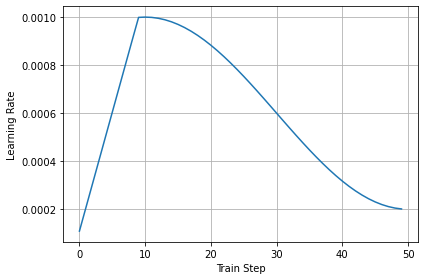

In [49]:
temp_learning_rate_schedule = CustomSchedule(HPARAMS.d_model)

plt.plot(temp_learning_rate_schedule(tf.range(HPARAMS.epochs, dtype = tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

plt.grid(True)
plt.tight_layout()
plt.show()

### **Callbacks**

In [50]:
def get_callbacks(
    model_name,
):    
    ## Checkpoint callback.
    ckpt_path = Path(f"ckpt/{model_name}") / Path("cp-{epoch:03d}-{val_loss:.4f}.ckpt")
    ckpt_path.parents[0].mkdir(parents = True, exist_ok = True)

    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        ckpt_path, 
        verbose = 0, 
        monitor = "val_loss", 
        save_weights_only = True, 
        save_best_only = True,
    )

    ## Learning rate schedular.
    lr_callback = tf.keras.callbacks.LearningRateScheduler(
        schedule = CustomSchedule(),
        verbose = 0,
    )

    ## TensorBoard callback.
    log_dir = Path(f"logs/fit/{model_name}")
    log_dir.parents[0].mkdir(parents = True, exist_ok = True)

    tb_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

    ## CSV Logger.
    filename = Path(f"logs/csv/{model_name}.csv")
    filename.parents[0].mkdir(parents = True, exist_ok = True)
    
    lg_callback = tf.keras.callbacks.CSVLogger(filename)

    return [cp_callback, lr_callback, tb_callback, lg_callback]

### **Loss Function and Metrics**

In [51]:
def loss_function(y_true, y_pred):
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    loss_ = tf.keras.losses.sparse_categorical_crossentropy(
        y_true, 
        y_pred, 
        from_logits = True,
    )

    mask = tf.cast(mask, dtype = loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)


def acc(y_true, y_pred):
    accuracies = tf.equal(
        y_true, 
        tf.cast(tf.argmax(y_pred, axis = 2), dtype = tf.float32)
    )

    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype = tf.float32)
    mask = tf.cast(mask, dtype = tf.float32)
    return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)

## **Train**

In [52]:
!rm -rf logs ckpt

In [53]:
transformer = Transformer(
    num_layers = HPARAMS.num_layers,
    d_model = HPARAMS.d_model,
    num_heads = HPARAMS.num_heads,
    dff = HPARAMS.dff,
    input_vocab_size = tokenizers.pt.get_vocab_size(),
    target_vocab_size = tokenizers.en.get_vocab_size(),
    pe_input = 1000,
    pe_target = 1000,
)

In [54]:
transformer.compile(
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(
        AdaBeliefOptimizer(
            HPARAMS.init_lr,
            epsilon = 1e-14,
            weight_decay = 0,
            rectify = False,
            print_change_log = False,
        )
    ),
    loss = loss_function,
    metrics = [acc],
    # steps_per_execution = HPARAMS.steps_per_execution,
)

In [55]:
_ = transformer.fit(
    tr_batches,
    validation_data = vl_batches,
    steps_per_epoch = HPARAMS.steps_per_epoch,
    validation_steps = HPARAMS.validation_steps,
    epochs = HPARAMS.epochs,
    verbose = 2,
    callbacks = get_callbacks(transformer.name),
)

Epoch 1/50
810/810 - 90s - loss: 5.2062 - acc: 0.1631 - val_loss: 5.1711 - val_acc: 0.2287
Epoch 2/50
810/810 - 69s - loss: 4.5779 - acc: 0.2435 - val_loss: 4.7372 - val_acc: 0.2726
Epoch 3/50
810/810 - 70s - loss: 4.3892 - acc: 0.2730 - val_loss: 4.1205 - val_acc: 0.3059
Epoch 4/50
810/810 - 69s - loss: 3.8089 - acc: 0.3166 - val_loss: 4.0911 - val_acc: 0.3596
Epoch 5/50
810/810 - 70s - loss: 3.5693 - acc: 0.3650 - val_loss: 3.8416 - val_acc: 0.4047
Epoch 6/50
810/810 - 70s - loss: 3.4302 - acc: 0.4044 - val_loss: 2.9147 - val_acc: 0.4467
Epoch 7/50
810/810 - 70s - loss: 3.0160 - acc: 0.4395 - val_loss: 3.0486 - val_acc: 0.4773
Epoch 8/50
810/810 - 70s - loss: 2.6214 - acc: 0.4709 - val_loss: 2.6993 - val_acc: 0.4984
Epoch 9/50
810/810 - 70s - loss: 2.4289 - acc: 0.4982 - val_loss: 2.3961 - val_acc: 0.5319
Epoch 10/50
810/810 - 70s - loss: 2.5542 - acc: 0.5184 - val_loss: 2.3979 - val_acc: 0.5541
Epoch 11/50
810/810 - 70s - loss: 2.3248 - acc: 0.5411 - val_loss: 2.1367 - val_acc: 0.55

In [87]:
transformer.summary()

Model: "transformer_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_2 (Encoder)          multiple                  1787008   
_________________________________________________________________
decoder_2 (Decoder)          multiple                  1955584   
_________________________________________________________________
dense_151 (Dense)            multiple                  904290    
_________________________________________________________________
activation_1 (Activation)    multiple                  0         
Total params: 4,646,882
Trainable params: 4,646,882
Non-trainable params: 0
_________________________________________________________________


### **Visualize the Results**

Load csv logs and plot.

In [58]:
csv_logs = Path(f"logs/csv/{transformer.name}.csv")
logs = pd.read_csv(csv_logs)

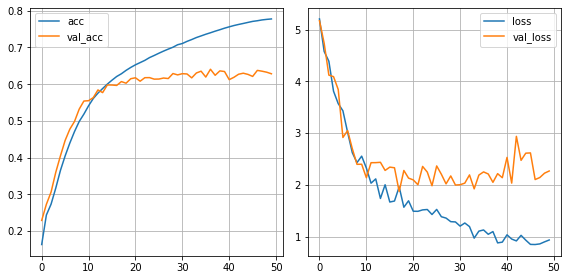

In [60]:
plt.figure(figsize = (8, 4), facecolor = "white")

plt.subplot(1, 2, 1)
plt.plot(logs.acc, label = "acc")
plt.plot(logs.val_acc, label = "val_acc")

plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(logs.loss, label = "loss")
plt.plot(logs.val_loss, label = "val_loss")

plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## **Evaluate**

In [67]:
def evaluate(sentence, max_length = 40):
    # inp sentence is portuguese, hence adding the start and end token
    sentence = tf.convert_to_tensor([sentence])
    sentence = tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # as the target is english, the first word to the transformer should be the
    # english start token.
    start, end = tokenizers.en.tokenize([""])[0]
    output = tf.convert_to_tensor([start])
    output = tf.expand_dims(output, 0)

    for i in range(max_length):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer((encoder_input,
                                                      output,
                                                      enc_padding_mask,
                                                      combined_mask,
                                                      dec_padding_mask), training = False)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.argmax(predictions, axis=-1)

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

        # return the result if the predicted_id is equal to the end token
        if predicted_id == end:
            break

    # output.shape (1, tokens)
    text = tokenizers.en.detokenize(output)[0]  # shape: ()

    tokens = tokenizers.en.lookup(output)[0]

    return text, tokens, attention_weights

In [68]:
def print_translation(sentence, tokens, ground_truth):
    print(f"{'Input':15s}: {sentence}")
    print(f"{'Prediction':15s}: {tokens.numpy().decode('utf-8')}")
    print(f"{'Ground truth':15s}: {ground_truth}")

In [69]:
sentence = "este é um problema que temos que resolver."
ground_truth = "this is a problem we have to solve ."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input          : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve .
Ground truth   : this is a problem we have to solve .


In [70]:
sentence = "os meus vizinhos ouviram sobre esta ideia."
ground_truth = "and my neighboring homes heard about this idea ."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input          : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


In [71]:
sentence = "vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram."
ground_truth = "so i \'ll just share with you some stories very quickly of some magical things that have happened ."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input          : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m going to really quickly share with you some stories from some magic things that happened .
Ground truth   : so i 'll just share with you some stories very quickly of some magical things that have happened .


## **Attention Plot**

In [72]:
sentence = "este é o primeiro livro que eu fiz."
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input          : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i made .
Ground truth   : this is the first book i've ever done.


In [73]:
def plot_attention_head(in_tokens, translated_tokens, attention):
    # The plot is of the attention when a token was generated.
    # The model didn't generate `<START>` in the output. Skip it.
    translated_tokens = translated_tokens[1:]

    ax = plt.gca()
    ax.matshow(attention)
    ax.set_xticks(range(len(in_tokens)))
    ax.set_yticks(range(len(translated_tokens)))

    labels = [label.decode("utf-8") for label in in_tokens.numpy()]
    ax.set_xticklabels(labels, rotation = 90)

    labels = [label.decode("utf-8") for label in translated_tokens.numpy()]
    ax.set_yticklabels(labels)

In [74]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(attention_weights["decoder_layer4_block2"], 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 11])

In [75]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

In [76]:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i',
       b'made', b'.', b'[END]'], dtype=object)>

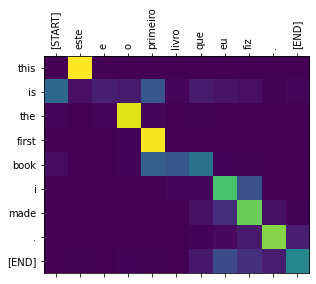

In [77]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [83]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
    in_tokens = tf.convert_to_tensor([sentence])
    in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
    in_tokens = tokenizers.pt.lookup(in_tokens)[0]
    in_tokens

    fig = plt.figure(figsize=(20, 8))

    for h, head in enumerate(attention_heads):
        ax = fig.add_subplot(2, 4, h + 1)

        plot_attention_head(in_tokens, translated_tokens, head)

        ax.set_xlabel(f'Head {h+1}')

    plt.tight_layout()
    plt.show()

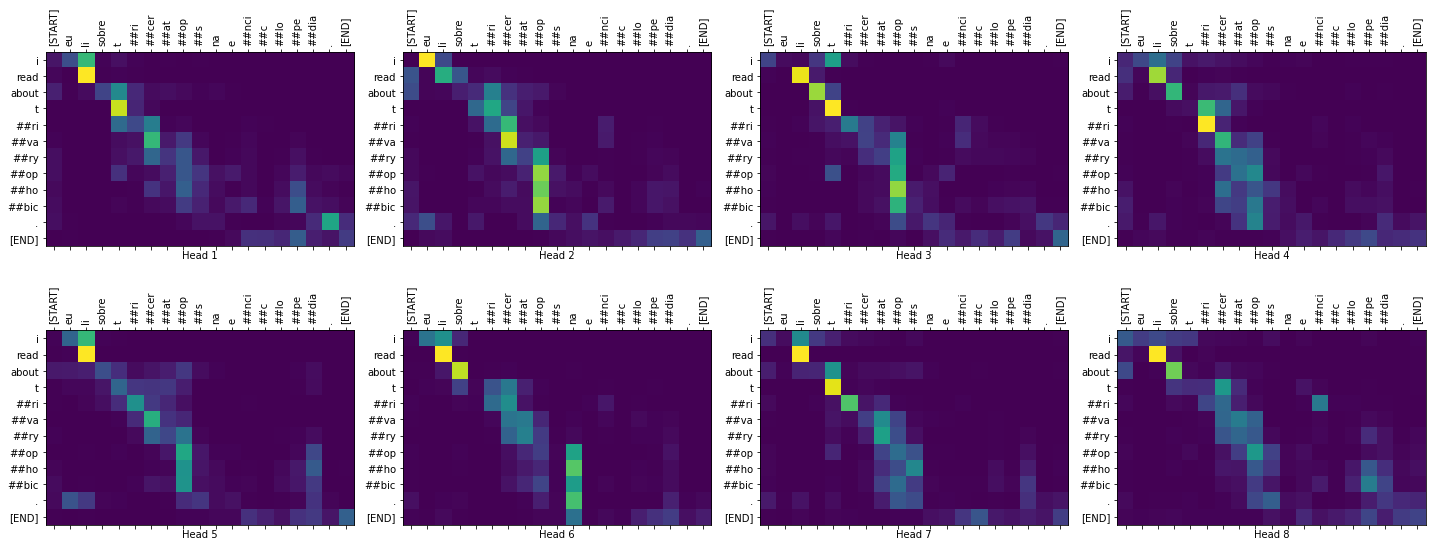

In [84]:
plot_attention_weights(sentence, translated_tokens,
                       attention_weights["decoder_layer4_block2"][0])

Input          : Eu li sobre triceratops na enciclopédia.
Prediction     : i read about trivaryophobic .
Ground truth   : I read about triceratops in the encyclopedia.


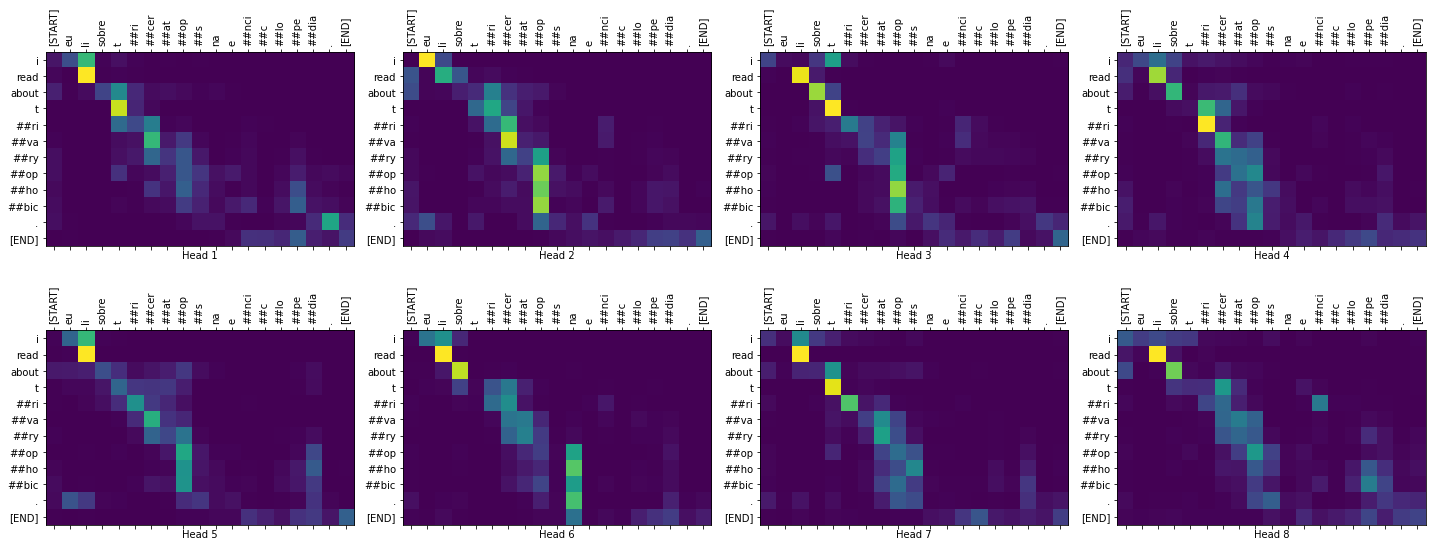

In [85]:
sentence = "Eu li sobre triceratops na enciclopédia."
ground_truth = "I read about triceratops in the encyclopedia."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens,
                       attention_weights["decoder_layer4_block2"][0])

## **Commit to Tensorboard Dev.**

In [ ]:
!tensorboard dev upload --logdir ./logs \
    --name "Experiment of 'Attention Is All You Need'" \
    --description "Implemented training results from the paper 'https://arxiv.org/abs/1706.03762'" \
    --one_shot

In [ ]:
from IPython import display

display.IFrame(
    src = "",
    width = "100%",
    height = "1000px"
)